<a href="https://colab.research.google.com/github/jusnaini/Applied-Machine-Learning/blob/main/Chapter%2010/Audio%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Classification with Convolutional Neural Networks

You are the leader of a group of climate scientists who are concerned about the planet's dwindling rain forests. The world loses up to 10 million acres of old-growth rain forests each year, much of it due to illegal logging. Deforestation from this and other causes accounts for about 10% of global carbon emissions. Your team plans to convert thousands of discarded smart phones into solar-powered listening devices and position them throughout the Amazon to transmit alerts in response to the sounds of chainsaws and truck engines. You need software to install on these phones that uses artificial intelligence (AI) to identify such sounds in real time. And you need it fast, because climate change won't wait.

Audio classification can be performed by converting audio streams into [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which provide visual representations of spectrums of frequencies as they vary over time, and classifying the spectrograms using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs). The spectrograms below were generated from WAV files with chainsaw sounds in the foreground and rainforest sounds in the background. Let's use Keras to build a CNN that can identify the tell-tale sounds of logging operations and distinguish them from ambient sounds such as wildlife and thunderstorms.

![](https://github.com/jusnaini/Applied-Machine-Learning/blob/main/Chapter%2010/Images/spectrograms.png?raw=1)

This notebook was inspired by the [Rainforest Connection](https://rfcx.org/), which uses recycled Android phones and a TensorFlow model to monitor rain forests for sounds indicative of illegal activity. For more information, see [The fight against illegal deforestation with TensorFlow](https://blog.google/technology/ai/fight-against-illegal-deforestation-tensorflow/) in the Google AI blog. It is just one example of how AI is making the world a better place.

## Generate spectrograms

The "Sounds" directory contains subdirectories named "background," "chainsaw," "engine," and "storm." Each subdirectory contains 100 WAV files. The WAV files in the "background" directory contain rainforest background noises only, while the files in the other subdirectories include the sounds of chainsaws, engines, and thunderstorms overlaid on the background noises. These WAV files were generated by using a soundscape-synthesis package named [Scaper](https://pypi.org/project/scaper/) to combine sounds in the public [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset with rainforest sounds obtained from YouTube.

The first step is to load the WAV files, use a Python package named [Librosa](https://librosa.org/) to generate spectrogram images from them, load the spectrograms into memory, and prepare them for use in training a CNN. To aid in this process, we'll define a pair of helper functions for creating spectrograms from WAV files and converting all the WAV files in a specified directory into spectrograms.

In [19]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

Create PNG files containing spectrograms from all the WAV files in the "Sounds/background" directory.

In [15]:
"""
- Downloads all filenames in the list from the chainsaw directory.
- Saves them to a local folder called chainsaw.
"""
import os
import requests
from urllib.parse import quote

# Directory to save downloaded files
DOWNLOAD_DIR = "Sounds/chainsaw"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# List of filenames (add more if needed)
filenames = [
    f"chainsaw_{i:02d}.wav" for i in range(100)
]

BASE_URL = "https://raw.githubusercontent.com/jusnaini/Applied-Machine-Learning/main/Chapter 10/Sounds/chainsaw/"

def download_file(filename):
    url = BASE_URL + quote(filename)
    local_path = os.path.join(DOWNLOAD_DIR, filename)
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"✓ Downloaded {filename}")
    except Exception as e:
        print(f"✗ Failed to download {filename}: {e}")

def main():
    for fname in filenames:
        download_file(fname)
    print("All downloads attempted.")

if __name__ == "__main__":
    main()

✓ Downloaded chainsaw_00.wav
✓ Downloaded chainsaw_01.wav
✓ Downloaded chainsaw_02.wav
✓ Downloaded chainsaw_03.wav
✓ Downloaded chainsaw_04.wav
✓ Downloaded chainsaw_05.wav
✓ Downloaded chainsaw_06.wav
✓ Downloaded chainsaw_07.wav
✓ Downloaded chainsaw_08.wav
✓ Downloaded chainsaw_09.wav
✓ Downloaded chainsaw_10.wav
✓ Downloaded chainsaw_11.wav
✓ Downloaded chainsaw_12.wav
✓ Downloaded chainsaw_13.wav
✓ Downloaded chainsaw_14.wav
✓ Downloaded chainsaw_15.wav
✓ Downloaded chainsaw_16.wav
✓ Downloaded chainsaw_17.wav
✓ Downloaded chainsaw_18.wav
✓ Downloaded chainsaw_19.wav
✓ Downloaded chainsaw_20.wav
✓ Downloaded chainsaw_21.wav
✓ Downloaded chainsaw_22.wav
✓ Downloaded chainsaw_23.wav
✓ Downloaded chainsaw_24.wav
✓ Downloaded chainsaw_25.wav
✓ Downloaded chainsaw_26.wav
✓ Downloaded chainsaw_27.wav
✓ Downloaded chainsaw_28.wav
✓ Downloaded chainsaw_29.wav
✓ Downloaded chainsaw_30.wav
✓ Downloaded chainsaw_31.wav
✓ Downloaded chainsaw_32.wav
✓ Downloaded chainsaw_33.wav
✓ Downloaded c

In [18]:
"""
  - Automatically lists all subfolders in the Sounds directory.
  - For each subfolder, lists all files and downloads any file ending with .wav
    into the corresponding local subfolder (mirroring the source structure).
"""

import os
import requests
from urllib.parse import quote

GITHUB_API = "https://api.github.com/repos/jusnaini/Applied-Machine-Learning/contents/Chapter%2010/Sounds"
RAW_BASE = "https://raw.githubusercontent.com/jusnaini/Applied-Machine-Learning/main/Chapter%2010/Sounds"
DOWNLOAD_ROOT = "Sounds"

def github_listdir(api_url):
    """List files and folders in a GitHub directory using the API."""
    r = requests.get(api_url)
    r.raise_for_status()
    return r.json()

def download_file(url, local_path):
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)
    print(f"✓ {local_path}")

def main():
    # List all subfolders in Sounds (e.g., 'background', 'chainsaw', etc.)
    folders = [item['name'] for item in github_listdir(GITHUB_API) if item['type'] == 'dir']

    for folder in folders:
        subfolder_api = f"{GITHUB_API}/{quote(folder)}"
        files = github_listdir(subfolder_api)
        for file in files:
            if file['type'] == 'file' and file['name'].endswith('.wav'):
                raw_url = f"{RAW_BASE}/{quote(folder)}/{quote(file['name'])}"
                local_path = os.path.join(DOWNLOAD_ROOT, folder, file['name'])
                try:
                    download_file(raw_url, local_path)
                except Exception as e:
                    print(f"✗ Failed {local_path}: {e}")

if __name__ == "__main__":
    main()

✓ Sounds/background/background_00.wav
✓ Sounds/background/background_01.wav
✓ Sounds/background/background_02.wav
✓ Sounds/background/background_03.wav
✓ Sounds/background/background_04.wav
✓ Sounds/background/background_05.wav
✓ Sounds/background/background_06.wav
✓ Sounds/background/background_07.wav
✓ Sounds/background/background_08.wav
✓ Sounds/background/background_09.wav
✓ Sounds/background/background_10.wav
✓ Sounds/background/background_11.wav
✓ Sounds/background/background_12.wav
✓ Sounds/background/background_13.wav
✓ Sounds/background/background_14.wav
✓ Sounds/background/background_15.wav
✓ Sounds/background/background_16.wav
✓ Sounds/background/background_17.wav
✓ Sounds/background/background_18.wav
✓ Sounds/background/background_19.wav
✓ Sounds/background/background_20.wav
✓ Sounds/background/background_21.wav
✓ Sounds/background/background_22.wav
✓ Sounds/background/background_23.wav
✓ Sounds/background/background_24.wav
✓ Sounds/background/background_25.wav
✓ Sounds/bac

In [20]:
create_pngs_from_wavs('Sounds/background', 'Spectrograms/background')

Create PNG files containing spectrograms from all the WAV files in the "Sounds/chainsaw" directory.

In [21]:
create_pngs_from_wavs('Sounds/chainsaw', 'Spectrograms/chainsaw')

Create PNG files containing spectrograms from all the WAV files in the "Sounds/engine" directory.

In [22]:
create_pngs_from_wavs('Sounds/engine', 'Spectrograms/engine')

Create PNG files containing spectrograms from all the WAV files in the "Sounds/storm" directory.

In [23]:
create_pngs_from_wavs('Sounds/storm', 'Spectrograms/storm')

Define two new helper functions for loading and displaying spectrograms and declare two Python lists — one to store spectrogram images, and another to store class labels.

In [24]:
from tensorflow.keras.preprocessing import image

def load_images_from_path(path, label):
    images, labels = [], []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file),
                      target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x, y = [], []

Load the background spectrogram images, add them to the list named `x`, and label them with 0s.

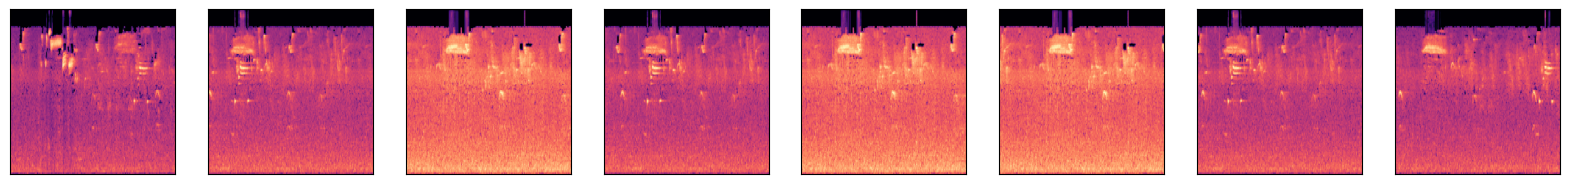

In [25]:
images, labels = load_images_from_path('Spectrograms/background', 0)
show_images(images)

x += images
y += labels

Load the chainsaw spectrogram images, add them to the list named `x`, and label them with 1s.

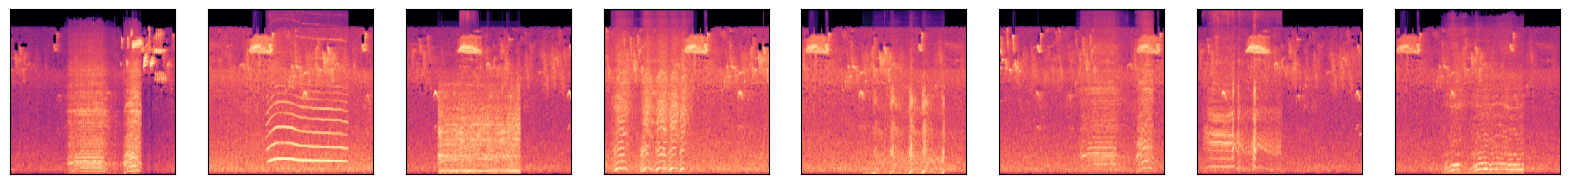

In [26]:
images, labels = load_images_from_path('Spectrograms/chainsaw', 1)
show_images(images)

x += images
y += labels

Load the engine spectrogram images, add them to the list named `x`, and label them with 2s.

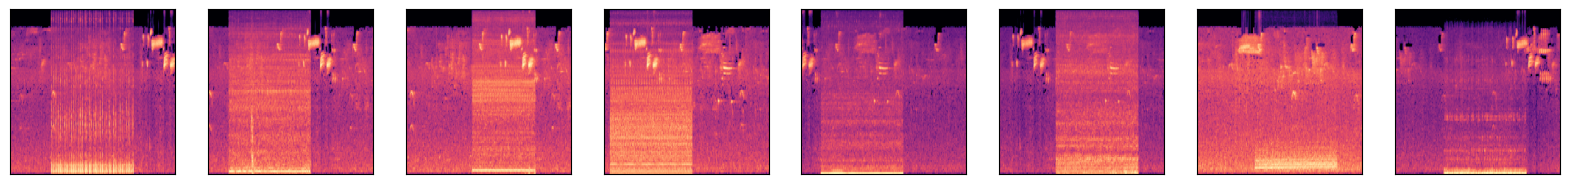

In [27]:
images, labels = load_images_from_path('Spectrograms/engine', 2)
show_images(images)

x += images
y += labels

Load the storm spectrogram images, add them to the list named `x`, and label them with 3s.

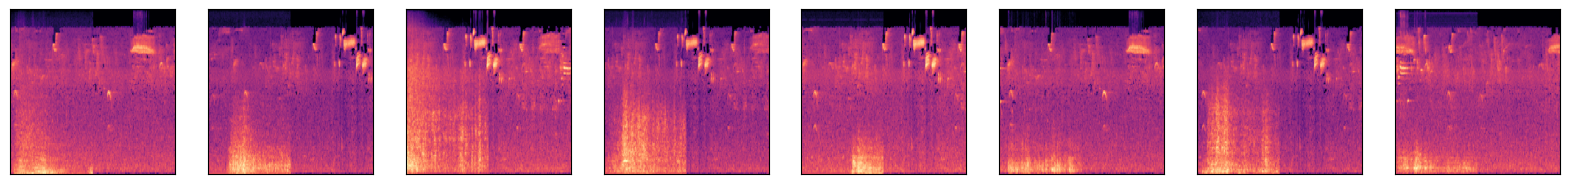

In [28]:
images, labels = load_images_from_path('Spectrograms/storm', 3)
show_images(images)

x += images
y += labels

Split the images and labels into two datasets — one for training, and one for testing. Then divide the pixel values by 255 and one-hot-encode the labels using Keras's [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function.

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input

x = preprocess_input(np.array(x))
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

## Use transfer learning to classify spectrograms

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated CNNs trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. Many pretrained CNNs are available in the public domain, and several are included with Keras. Let's use [`MobileNetV2`](https://keras.io/api/applications/mobilenet/), a pretrained CNN from Google that is optimized for mobile devices, to extract features from spectrogram images.

> `MobileNetV2` requires less processing power and has a smaller memory footprint than CNNs such as `ResNet50V2`. That's why it is ideal for mobile devices. You can learn more about it in the [Google AI blog](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html).

Start by calling Keras's [MobileNetV2](https://keras.io/api/applications/mobilenet/) function to instantiate `MobileNetV2` without the classification layers. Use the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input) function for `MobileNet` networks to preprocess the training and testing images. Then run both datasets through `MobileNetV2` to extract features.

In [30]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

train_features = base_model.predict(x_train)
test_features = base_model.predict(x_test)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


Define a neural network to classify features extracted by `MobileNetV2`.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the network with features extracted by `MobileNetV2`.

In [32]:
hist = model.fit(train_features, y_train, validation_data=(test_features, y_test), batch_size=10, epochs=10)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 545ms/step - accuracy: 0.5841 - loss: 24.6734 - val_accuracy: 0.9250 - val_loss: 1.9743
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step - accuracy: 0.8996 - loss: 3.3001 - val_accuracy: 0.8917 - val_loss: 5.4568
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - accuracy: 0.9567 - loss: 1.7175 - val_accuracy: 0.9417 - val_loss: 2.0073
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 556ms/step - accuracy: 0.9941 - loss: 0.1209 - val_accuracy: 0.8833 - val_loss: 3.0918
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 574ms/step - accuracy: 0.9687 - loss: 0.6624 - val_accuracy: 0.9250 - val_loss: 3.0698
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 549ms/step - accuracy: 0.9962 - loss: 0.0258 - val_accuracy: 0.9417 - val_loss: 3.1208
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.9933 - loss: 0.1424 - val_accuracy: 0.9000 - val_loss: 3.4446
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 540ms/step - accuracy: 0.9586 - loss: 0.6114 - val_acc

Plot the training and validation accuracy.

[]

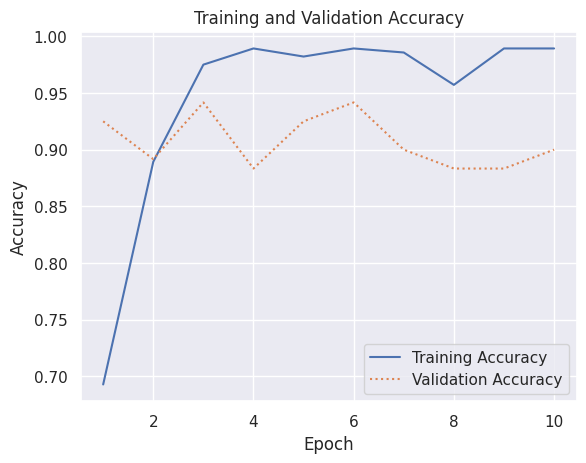

In [33]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run the test images through the network and use a confusion matrix to assess the results.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


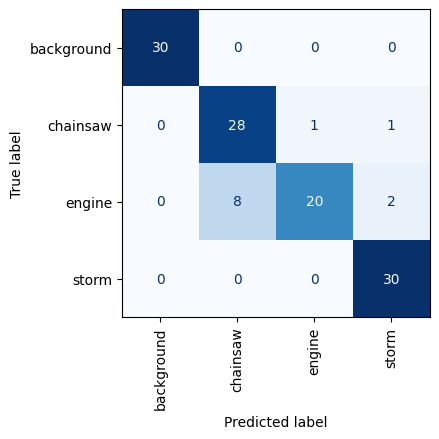

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(False)

y_pred = model.predict(test_features)
class_labels = ['background', 'chainsaw', 'engine', 'storm']

cmd.from_predictions(y_test, y_pred.argmax(axis=1),
                     display_labels=class_labels, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

The network is pretty adept at identifying clips that don't contain the sounds of chainsaw or engines. It sometimes confuses chainsaw sounds and engine sounds, but that's OK, because the presence of either might indicate illicit activity in a rain forest.

## Test with unrelated WAV files

The "Sounds" directory has a subdirectory named "samples" containing WAV files that the CNN was neither trained nor tested with. The WAV files bear no relation to the samples used for training and testing; they were extracted from a YouTube video documenting Brazil's efforts to curb illegal logging. Let's use the model trained in the previous exercise to analyze these files for sounds of logging activity. Start by creating a spectrogram from the first sample WAV file, which contains audio of loggers cutting down trees in the Amazon.

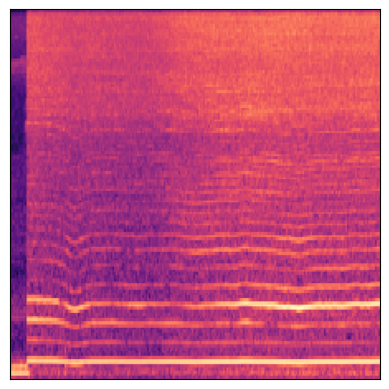

In [35]:
create_spectrogram('Sounds/samples/sample1.wav', 'Spectrograms/sample1.png')

x = image.load_img('Spectrograms/sample1.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the spectrogram image, pass it to `MobileNetV2` for feature extraction, and classify the features.

In [36]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
background: 0.0
chainsaw: 1.0
engine: 7.839215249786306e-31
storm: 0.0


Create a spectrogram from a WAV file that includes the sounds of a logging truck rumbling through the rain forest.

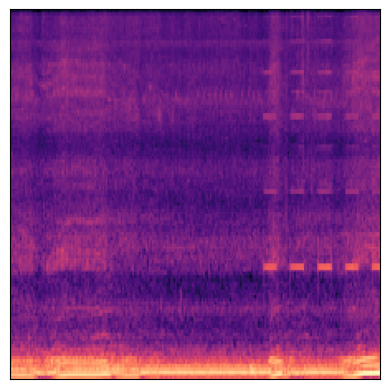

In [37]:
create_spectrogram('Sounds/samples/sample2.wav', 'Spectrograms/sample2.png')

x = image.load_img('Spectrograms/sample2.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the spectrogram image, pass it to `MobileNetV2` for feature extraction, and classify the features.

In [38]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
background: 0.0
chainsaw: 1.8257822775323917e-23
engine: 1.0
storm: 3.645343726242672e-35


If the network got either of the samples wrong, try training it again with the output from `MobileNetV2`. Remember that a neural network will train differently every time, in part because Keras initializes the weights and biases with small random values. In the real world, data scientists often train a neural network 20 or more times and average the results to quantify its accuracy.